<a href="https://colab.research.google.com/github/WanjohiChristopher/Zindi-Kenya-Sign-Language-Classification/blob/main/Kenyan_Sign_LanguageClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q  fastai==1.0.61

In [2]:
# check version of fastai
import fastai

fastai.__version__

'1.0.61'

In [3]:
# connect to gdrive
from google.colab import drive
drive.mount("/content/drive")


Mounted at /content/drive


In [4]:
import numpy as np 
import pandas as pd 

from fastai import *
from fastai.vision import *
from pathlib import Path
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [5]:

image_path = '/content/drive/MyDrive/ZindiSignlanguage/Images'

### tfms helps to do data augmentation on the data to have a better pixel values

In [29]:
tfms=get_transforms(do_flip=True,flip_vert=True,max_lighting=0.5,max_zoom=2.0,max_warp=0.2,max_rotate=45)

### Read the data and pass the data augmentation function

In [30]:
df = pd.read_csv("/content/drive/MyDrive/ZindiSignlanguage/Train.csv")

In [31]:
df.head()

,img_IDS,Label
0,ImageID_33HMDMJ3,Temple
1,ImageID_V5POEX4O,Church
2,ImageID_89CCCCW6,Enough/Satisfied
3,ImageID_GNJXOWX5,Me
4,ImageID_7Q9LOP7R,Love


In [32]:
data = ImageDataBunch.from_df(image_path,
                              df,
                              size=224,
                              valid_pct=0.20,
                              ds_tfms=tfms,
                              num_workers=3,
                              bs=8,
                             suffix='.jpg').normalize(imagenet_stats)

In [33]:
# There are 9 classes!
print(data.c) 

9


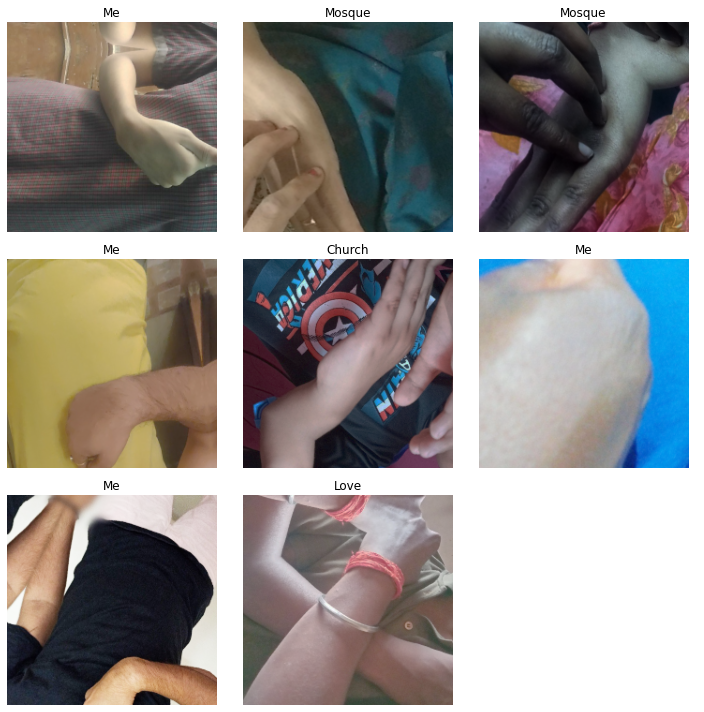

In [34]:
# Look at some examples
data.show_batch(rows=3, figsize=(10, 10)) 

### Modelling
Using Efficientnet Model

In [35]:
!pip install efficientnet-pytorch

In [36]:
from efficientnet_pytorch import EfficientNet

In [39]:
#learn = cnn_learner(data, models.resnet18, metrics=[error_rate, accuracy])
model = EfficientNet.from_name('efficientnet-b0')
model._fc = nn.Linear(1280, data.c)
learn = Learner(data, model,metrics=[error_rate, accuracy])



In [ ]:
# Fit
num_epochs =5
learn.fit_one_cycle(num_epochs, 1e-2)

epoch,train_loss,valid_loss,error_rate,accuracy,time


## predict on test set

In [16]:
test_df = pd.read_csv("/content/drive/MyDrive/ZindiSignlanguage/Test.csv")

In [17]:
test_df.head()

,img_IDS
0,ImageID_USRB8QNG
1,ImageID_SZ8D1ZJI
2,ImageID_4OJO2F8J
3,ImageID_IEE4XV0B
4,ImageID_BP0O0WZ9


In [18]:
test = ImageList.from_df(test_df, image_path, suffix='.jpg')

In [19]:
data.add_test(test)

In [20]:
#predictions

In [21]:
preds_test,y_test = learn.get_preds(DatasetType.Test)

In [ ]:
preds_test[:,i]

In [23]:
y_test

tensor([0, 0, 0,  ..., 0, 0, 0])

In [25]:
sub=pd.read_csv('/content/drive/MyDrive/ZindiSignlanguage/SampleSubmission.csv')
k=[]
for col in sub.columns: 
    k.append(col) # creating list of the label

In [ ]:
k

In [26]:
import os
submission = pd.DataFrame()
submission["ID"] = test_df["img_IDS"]
for i, c in enumerate(learn.data.classes):
    print(c)
    submission[c] = preds_test[:,i]
submission.head()

Church
Enough/Satisfied
Friend
Love
Me
Mosque
Seat
Temple
You


,ID,Church,Enough/Satisfied,Friend,Love,Me,Mosque,Seat,Temple,You
0,ImageID_USRB8QNG,0.113264,0.117354,0.099489,0.116782,0.111690,0.103532,0.119724,0.117023,0.101144
1,ImageID_SZ8D1ZJI,0.113579,0.117605,0.096627,0.113002,0.114767,0.103591,0.115029,0.123268,0.102533
2,ImageID_4OJO2F8J,0.116929,0.108538,0.122420,0.095469,0.118952,0.109000,0.112943,0.104434,0.111316
3,ImageID_IEE4XV0B,0.114869,0.117617,0.090785,0.123257,0.104733,0.106430,0.117184,0.123342,0.101785
4,ImageID_BP0O0WZ9,0.115732,0.114323,0.090242,0.118706,0.109364,0.106150,0.116197,0.123330,0.105956


In [27]:
submission.to_csv('subs.csv', index=False)